In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# Creating multiple dataframe with different "look back" periods
# The periods are 1 day, 3 days. 7 days. 15 days. 30 days and 60 days
# The look back periods should be in the form of a list
# For example, if the look back period is 3, then the dataframe should have 3 columns
# Date, Close, [Close(t-1), Close(t-2), Close(t-3)]

def create_look_back_arrays(df, window_size = 1):
    df = df.drop(columns = ['Date'])
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i+window_size])
        Y.append(df_as_np[i+window_size])
    return np.array(X), np.array(Y)

In [3]:
df = pd.read_csv('../Data/ethereum_data.csv')

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...,...
1660,2022-05-27,1802.543823,1814.656494,1721.264771,1724.922852,1724.922852,25470760032
1661,2022-05-28,1724.635986,1757.941772,1724.635986,1757.941772,1757.941772,23214777872
1662,2022-05-29,1792.184448,1818.776611,1765.937378,1812.031006,1812.031006,10642556101
1663,2022-05-30,1811.885986,2005.210815,1804.456055,1996.441284,1996.441284,19580808705


In [5]:
df = df[['Date', 'Close']]

In [6]:
df

,Date,Close
0,2017-11-09,320.884003
1,2017-11-10,299.252991
2,2017-11-11,314.681000
3,2017-11-12,307.907990
4,2017-11-13,316.716003
...,...,...
1660,2022-05-27,1724.922852
1661,2022-05-28,1757.941772
1662,2022-05-29,1812.031006
1663,2022-05-30,1996.441284


In [7]:
# Scale the values in the Close column
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

/var/folders/76/w363ly_90ln6pf3txlrc64bw0000gn/T/ipykernel_28002/3875126601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


In [8]:
df

,Date,Close
0,2017-11-09,0.050040
1,2017-11-10,0.045464
2,2017-11-11,0.048727
3,2017-11-12,0.047295
4,2017-11-13,0.049158
...,...,...
1660,2022-05-27,0.347016
1661,2022-05-28,0.354000
1662,2022-05-29,0.365441
1663,2022-05-30,0.404446


In [9]:
x_1, y_1 = create_look_back_arrays(df, 1)
x_3, y_3 = create_look_back_arrays(df, 3)
x_7, y_7 = create_look_back_arrays(df, 7)
x_15, y_15 = create_look_back_arrays(df, 15)
x_30, y_30 = create_look_back_arrays(df, 30)
x_60, y_60 = create_look_back_arrays(df, 60)

# 1 Day look back window

In [10]:
x_1.shape, y_1.shape

((1664, 1, 1), (1664, 1))

In [11]:
X_1_train, y_1_train = x_1[:1300], y_1[:1300]
X_1_val, y_1_val = x_1[1300:1500], y_1[1300:1500]
X_1_test, y_1_test = x_1[1500:], y_1[1500:]
X_1_train.shape, y_1_train.shape, X_1_val.shape, y_1_val.shape, X_1_test.shape, y_1_test.shape

((1300, 1, 1), (1300, 1), (200, 1, 1), (200, 1), (164, 1, 1), (164, 1))

In [12]:
model_1 = Sequential()
model_1.add(InputLayer(input_shape = (1, 1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, activation = 'relu'))
model_1.add(Dense(1, activation = 'linear'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
cp = ModelCheckpoint('models/lstm_1.h5', save_best_only = True)
model_1.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [14]:
model_1.fit(X_1_train, y_1_train, epochs = 200, validation_data = (X_1_val, y_1_val), callbacks = [cp])

Epoch 1/200
41/41 [==============================] - 1s 6ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594 - mean_absolute_error: 0.0870 - val_loss: 0.4543 - val_root_mean_squared_error: 0.6740 - val_mean_absolute_error: 0.6500
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0224 - root_mean_squared_error: 0.1495 - mean_absolute_error: 0.0760 - val_loss: 0.4234 - val_root_mean_squared_error: 0.6507 - val_mean_absolute_error: 0.6265
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0200 - root_mean_squared_error: 0.1415 - mean_absolute_error: 0.0713 - val_loss: 0.3964 - val_root_mean_squared_error: 0.6296 - val_mean_absolute_error: 0.6053
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0182 - root_mean_squared_error: 0.1351 - mean_absolute_error: 0.0704 - val_loss: 0.3712 - val_root_mean_squared_error: 0.6092 - val_mean_absolute_error: 0.5848
Epoch 5/200
 1/41 [..............................] - ETA: 0s

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 1ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - mean_absolute_error: 0.0704 - val_loss: 0.3507 - val_root_mean_squared_error: 0.5922 - val_mean_absolute_error: 0.5677
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0159 - root_mean_squared_error: 0.1260 - mean_absolute_error: 0.0711 - val_loss: 0.3307 - val_root_mean_squared_error: 0.5751 - val_mean_absolute_error: 0.5505
Epoch 7/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - mean_absolute_error: 0.0719 - val_loss: 0.3138 - val_root_mean_squared_error: 0.5602 - val_mean_absolute_error: 0.5357
Epoch 8/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0144 - root_mean_squared_error: 0.1201 - mean_absolute_error: 0.0727 - val_loss: 0.2986 - val_root_mean_squared_error: 0.5464 - val_mean_absolute_error: 0.5221
Epoch 9/200
41/41 [==============================] - 0s 1ms/step - loss:

In [15]:
model_1 = load_model('models/lstm_1.h5')

In [16]:
test_1_predictions = model_1.predict(X_1_test)
test_results = pd.DataFrame({'Actual': y_1_test.flatten(), 'Predicted': test_1_predictions.flatten()})
test_results

6/6 [==============================] - 0s 609us/step


,Actual,Predicted
0,0.811858,0.795907
1,0.814238,0.789041
2,0.832516,0.791060
3,0.824444,0.806579
4,0.851078,0.799721
...,...,...
159,0.347016,0.368955
160,0.354000,0.351520
161,0.365441,0.358802
162,0.404446,0.370750


In [17]:
# Creating a dataframe with the actual and predicted values without the scaling 
test_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1501:].flatten(), 'Predicted': scaler.inverse_transform(test_1_predictions).flatten()})
test_results_unscaled

,Actual,Predicted
0,3922.592529,3847.183105
1,3933.844482,3814.721680
2,4020.260010,3824.262939
3,3982.099609,3897.635498
4,4108.015625,3865.213867
...,...,...
159,1724.922852,1828.646118
160,1757.941772,1746.218628
161,1812.031006,1780.646362
162,1996.441284,1837.130859


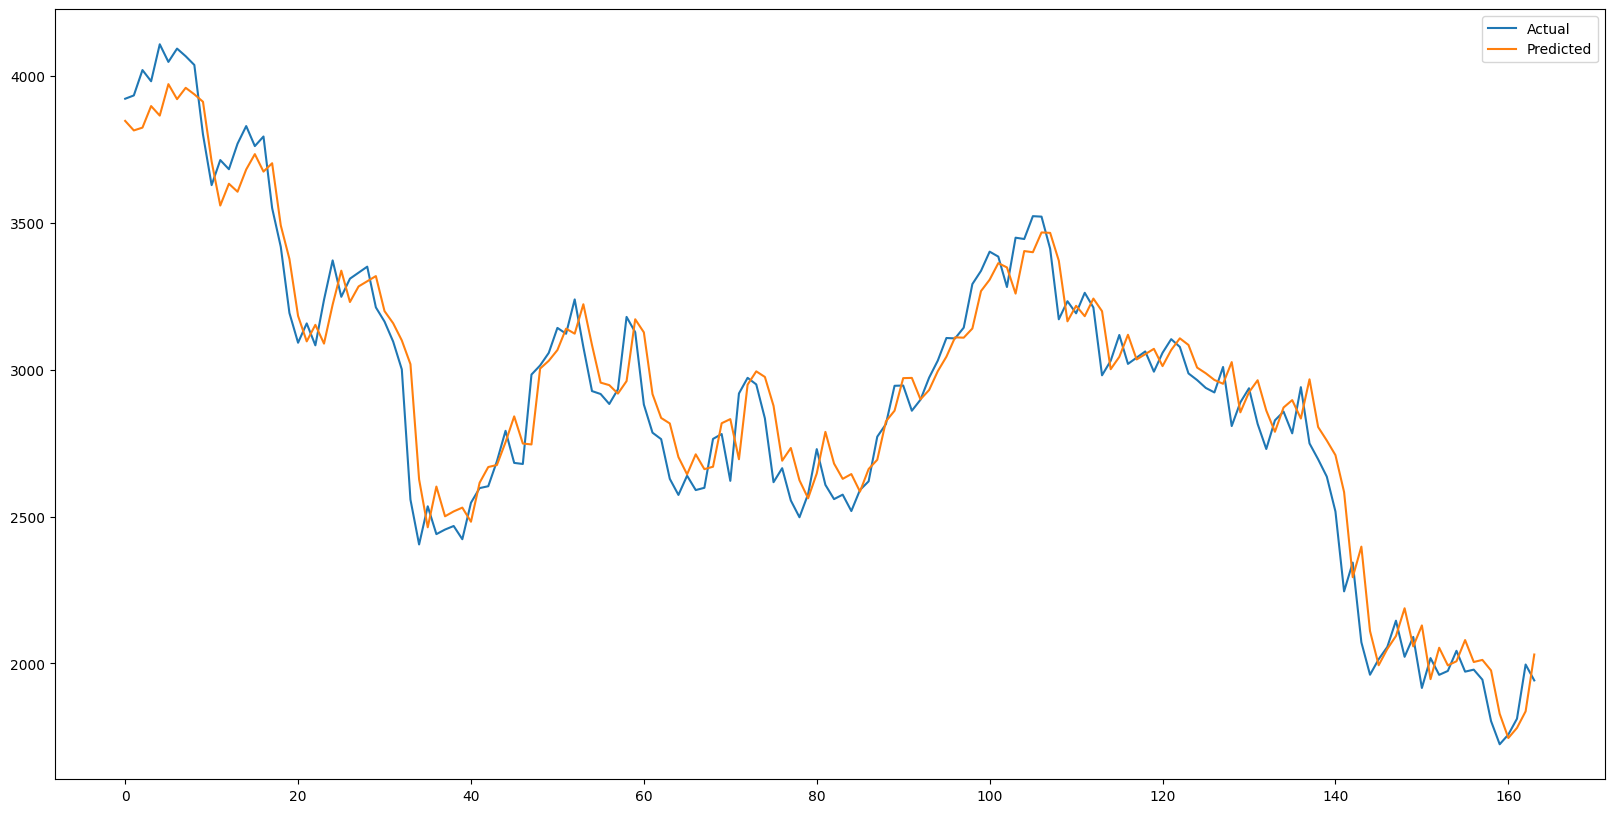

In [18]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [19]:
# Calculating the RMSE and MAE
rmse = np.sqrt(np.mean((test_results_unscaled['Actual'] - test_results_unscaled['Predicted'])**2))
mae = np.mean(np.abs(test_results_unscaled['Actual'] - test_results_unscaled['Predicted']))
rmse, mae

(120.81822442595443, 95.4862827207984)

# 3 Day Look Back Window

In [20]:
x_3.shape, y_3.shape

((1662, 3, 1), (1662, 1))

In [21]:
X_3_train, y_3_train = x_3[:1300], y_3[:1300]
X_3_val, y_3_val = x_3[1300:1500], y_3[1300:1500]
X_3_test, y_3_test = x_3[1500:], y_3[1500:]
X_3_train.shape, y_3_train.shape, X_3_val.shape, y_3_val.shape, X_3_test.shape, y_3_test.shape

((1300, 3, 1), (1300, 1), (200, 3, 1), (200, 1), (162, 3, 1), (162, 1))

In [22]:
model_3 = Sequential()
model_3.add(InputLayer(input_shape = (3, 1)))
model_3.add(LSTM(64))
model_3.add(Dense(8, activation = 'relu'))
model_3.add(Dense(1, activation = 'linear'))

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
cp3 = ModelCheckpoint('models/lstm_3.h5', save_best_only = True)
model_3.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [24]:
model_3.fit(X_3_train, y_3_train, epochs = 200, validation_data = (X_3_val, y_3_val), callbacks = [cp3])

Epoch 1/200
41/41 [==============================] - 1s 6ms/step - loss: 0.0247 - root_mean_squared_error: 0.1572 - mean_absolute_error: 0.0841 - val_loss: 0.4194 - val_root_mean_squared_error: 0.6476 - val_mean_absolute_error: 0.6243
Epoch 2/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0193 - root_mean_squared_error: 0.1391 - mean_absolute_error: 0.0699 - val_loss: 0.3593 - val_root_mean_squared_error: 0.5994 - val_mean_absolute_error: 0.5763
Epoch 3/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0157 - root_mean_squared_error: 0.1255 - mean_absolute_error: 0.0666 - val_loss: 0.3012 - val_root_mean_squared_error: 0.5489 - val_mean_absolute_error: 0.5262
Epoch 4/200
 1/41 [..............................] - ETA: 0s - loss: 0.0190 - root_mean_squared_error: 0.1377 - mean_absolute_error: 0.0731

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 2ms/step - loss: 0.0132 - root_mean_squared_error: 0.1147 - mean_absolute_error: 0.0656 - val_loss: 0.2547 - val_root_mean_squared_error: 0.5047 - val_mean_absolute_error: 0.4825
Epoch 5/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - mean_absolute_error: 0.0647 - val_loss: 0.2150 - val_root_mean_squared_error: 0.4637 - val_mean_absolute_error: 0.4423
Epoch 6/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978 - mean_absolute_error: 0.0622 - val_loss: 0.1802 - val_root_mean_squared_error: 0.4245 - val_mean_absolute_error: 0.4042
Epoch 7/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0081 - root_mean_squared_error: 0.0899 - mean_absolute_error: 0.0590 - val_loss: 0.1483 - val_root_mean_squared_error: 0.3851 - val_mean_absolute_error: 0.3659
Epoch 8/200
41/41 [==============================] - 0s 2ms/step - loss:

In [25]:
model_3 = load_model('models/lstm_3.h5')

In [26]:
test_3_predictions = model_3.predict(X_3_test)
test_3_results = pd.DataFrame({'Actual': y_3_test.flatten(), 'Predicted': test_3_predictions.flatten()})
test_3_results

6/6 [==============================] - 0s 760us/step


,Actual,Predicted
0,0.832516,0.814383
1,0.824444,0.814721
2,0.851078,0.820650
3,0.838380,0.831487
4,0.847961,0.834475
...,...,...
157,0.347016,0.401405
158,0.354000,0.382958
159,0.365441,0.363991
160,0.404446,0.361155


In [27]:
# Creating a dataframe with the actual and predicted values without the scaling
test_3_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1503:].flatten(), 'Predicted': scaler.inverse_transform(test_3_predictions).flatten()})

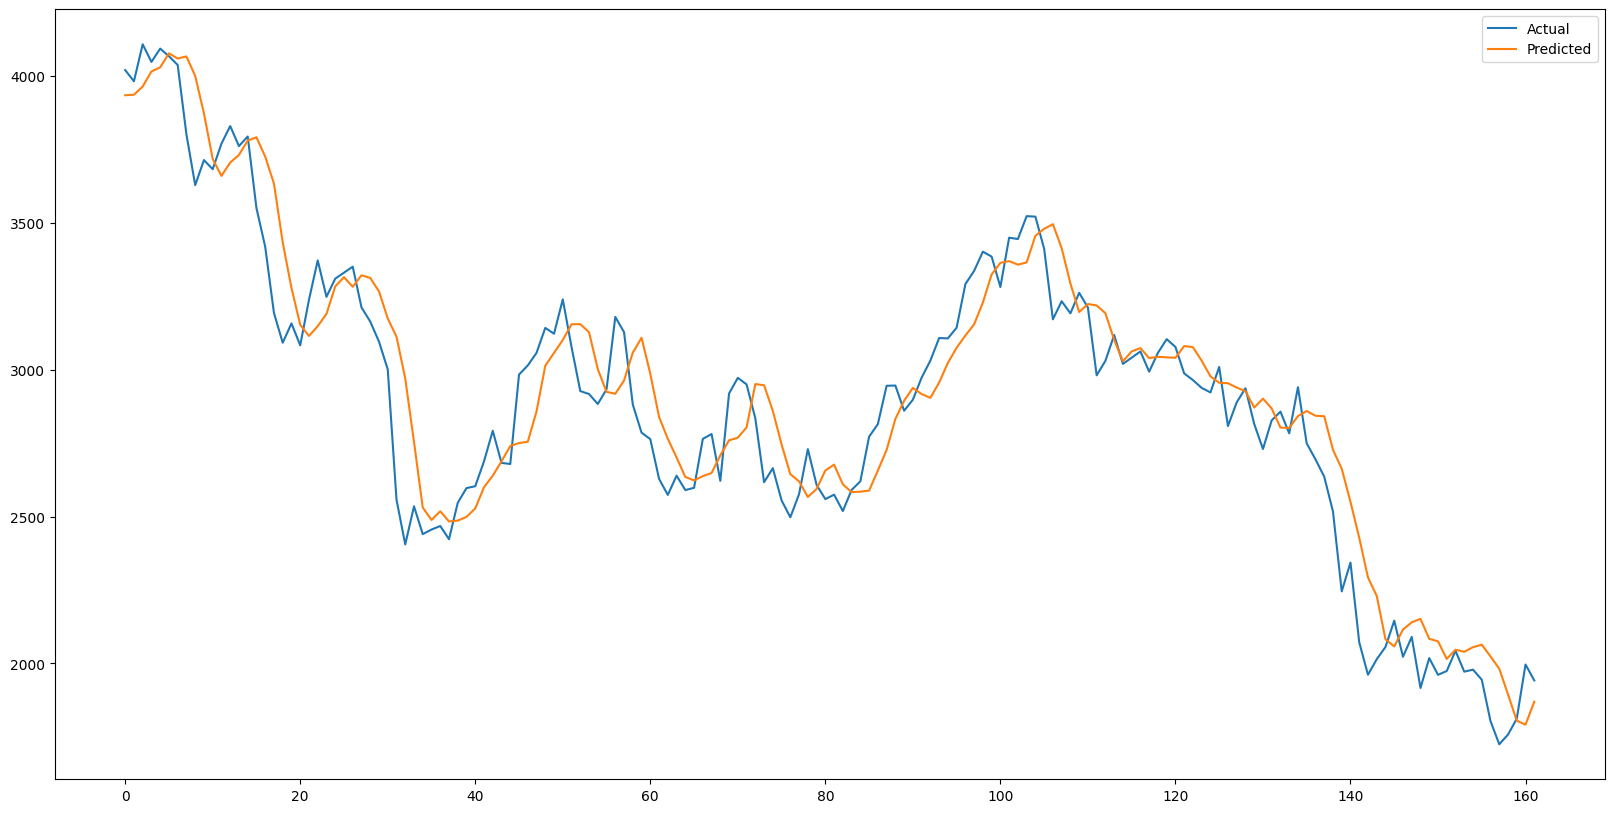

In [28]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_3_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_3_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [29]:
# Calculating the RMSE and MAE
rmse = np.sqrt(np.mean((test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted'])**2))
mae = np.mean(np.abs(test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted']))
rmse, mae

(164.4933599699754, 128.3894246419271)